The Titanic competion is a classification problem: given some info on a passenger, we determine if they survived.

So, two categories represented by the "Survived" boolean columns in the dataset: Yes=1 and Dead=0.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


# Step 1: Gather the Data

### Checking the format of the data

In [2]:
train_data = pd.read_csv("../input/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../input/test.csv", index_col="PassengerId")

train_data.head()
# test_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Step 2: Prepare the Data

In [4]:
# Separate target from predictors
y = train_data['Survived']
X_full = train_data.drop(['Survived'], axis=1)

In [5]:
(y == 1).sum()

342

In [6]:
# Drop columns with missing values (simplest approach)
cols_with_na = [col for col in X_full.columns if X_full[col].isnull().any()]
X_reduced = X_full.drop(cols_with_na, axis=1)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
def has_low_cardinality(df, col):
    is_categorical = (df[col].dtype == "object")
    has_low_card = (df[col].nunique() < 10)
    return (is_categorical and has_low_card)

categorical_cols = [col for col in X_reduced.columns if has_low_cardinality(X_reduced, col)]

# Select numerical columns
numerical_cols = [col for col in X_reduced.columns if X_reduced[col].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

X = X_reduced[my_cols].copy()
X_test = test_data[my_cols].copy()

print("Predictors are : ", my_cols)
print("Numerical cols : ", numerical_cols)
print("Categorical cols : ", categorical_cols)

Predictors are :  ['Sex', 'Pclass', 'SibSp', 'Parch', 'Fare']
Numerical cols :  ['Pclass', 'SibSp', 'Parch', 'Fare']
Categorical cols :  ['Sex']


In [7]:
X.head()

,Sex,Pclass,SibSp,Parch,Fare
PassengerId,,,,,
1,male,3,1,0,7.2500
2,female,1,1,0,71.2833
3,female,3,0,0,7.9250
4,female,1,1,0,53.1000
5,male,3,0,0,8.0500


In [8]:
# Divide data into training and validation subsets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

### Defining the Preprocessing Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Checking the preprocessing pipeline

In [10]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)
print(X_train.head())
print(X_train_transformed[:5])

                Sex  Pclass  SibSp  Parch     Fare
PassengerId                                       
141          female       3      0      2  15.2458
440            male       2      0      0  10.5000
818            male       2      1      1  37.0042
379            male       3      0      0   4.0125
492            male       3      0      0   7.2500
[[ 3.      0.      2.     15.2458  1.      0.    ]
 [ 2.      0.      0.     10.5     0.      1.    ]
 [ 2.      1.      1.     37.0042  0.      1.    ]
 [ 3.      0.      0.      4.0125  0.      1.    ]
 [ 3.      0.      0.      7.25    0.      1.    ]]


# Step 3: Define the Classifier Model

### Approach 0: DecisionTreeClassifier

Model and Pipeline

In [11]:
from sklearn.tree import DecisionTreeClassifier



Training and Validation

In [12]:
y.size

891

In [13]:
# for data validation
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# pipeline_0.fit(X_train, y_train)

# y_preds = pipeline_0.predict(X_valid)
# score = accuracy_score(y_valid, y_preds)
# print(f"Decision Tree Model has score = {score}")

model_0 = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0011, class_weight='balanced')

pipeline_0 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_0)
])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)

from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=50)

scores = cross_val_score(
    pipeline_0, X, y,
    cv=rskf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=False
)
# print(f"Using cross-validation = {scores}")

score_mean = scores.mean()
score_std = scores.std()

print(f"Score mean = {score_mean} +- {score_std/(scores.size)**0.5}")
print(f"Score variance = {score_std}")

# plot_confusion_matrix(model_0, preprocessor.transform(X_valid), y_valid)

Score mean = 0.8042626716604244 +- 0.0017394608186037705
Score variance = 0.03889552634595462


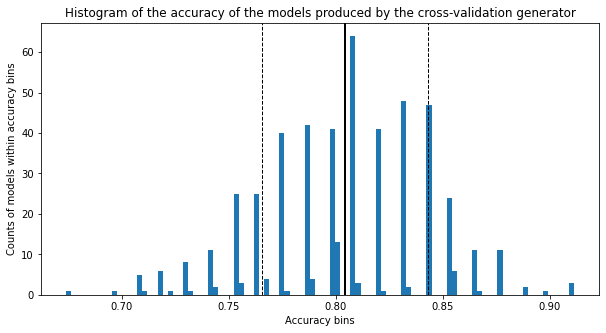

Score mean = 0.8043
Score variance = 0.0389
Score -1sigma = 0.7654
Score +1sigma = 0.8432


In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(scores, bins=100)
ax.set_ylabel('Counts of models within accuracy bins')
ax.set_xlabel('Accuracy bins')
ax.set_title('Histogram of the accuracy of the models produced by the cross-validation generator')
ax.axvline(score_mean, color='k', lw=2)
ax.axvline(score_mean - score_std, color='k', lw=1, ls='--')
ax.axvline(score_mean + score_std, color='k', lw=1, ls='--')

plt.show()

print(
    f"Score mean = {score_mean:.4f}\n"
    f"Score variance = {score_std:.4f}\n"
    f"Score -1sigma = {score_mean - score_std:.4f}\n"
    f"Score +1sigma = {score_mean + score_std:.4f}"
)

We obtain a binomial distribution (actually multiple binomial distribution depending of the number of samples populaitng each split of the Kfold generator). That is A-okay !

### Small submission, just to see on kaggle if improvment

In [15]:
model_sub = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0011, class_weight='balanced')

pipeline_sub = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_sub)
])

pipeline_sub.fit(X, y)
predictions = pipeline_sub.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Investigation of the Tree

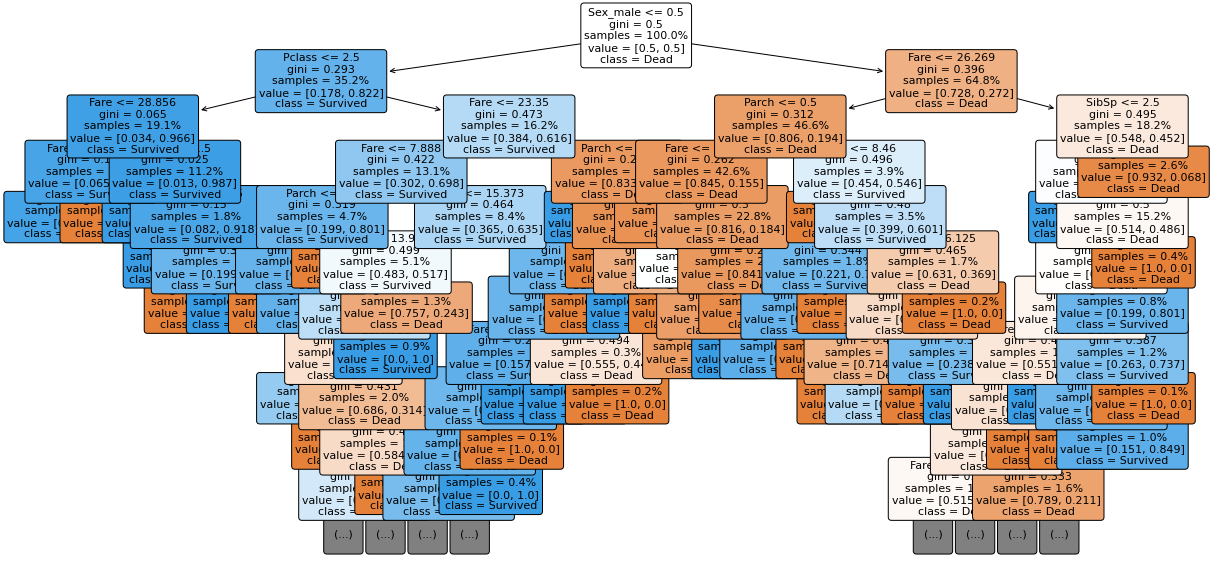

In [16]:
# getting the feature names
from aux_functions import get_column_names_from_ColumnTransformer
feature_names = get_column_names_from_ColumnTransformer(preprocessor)

from sklearn import tree
fig = plt.subplots(figsize=(20,10))
tree.plot_tree(
    model_sub,
    feature_names=feature_names,
    max_depth=10,
    class_names=["Dead", "Survived"],
    filled=True,
    proportion=True,
    fontsize=11,
    rounded=True
)
plt.show()

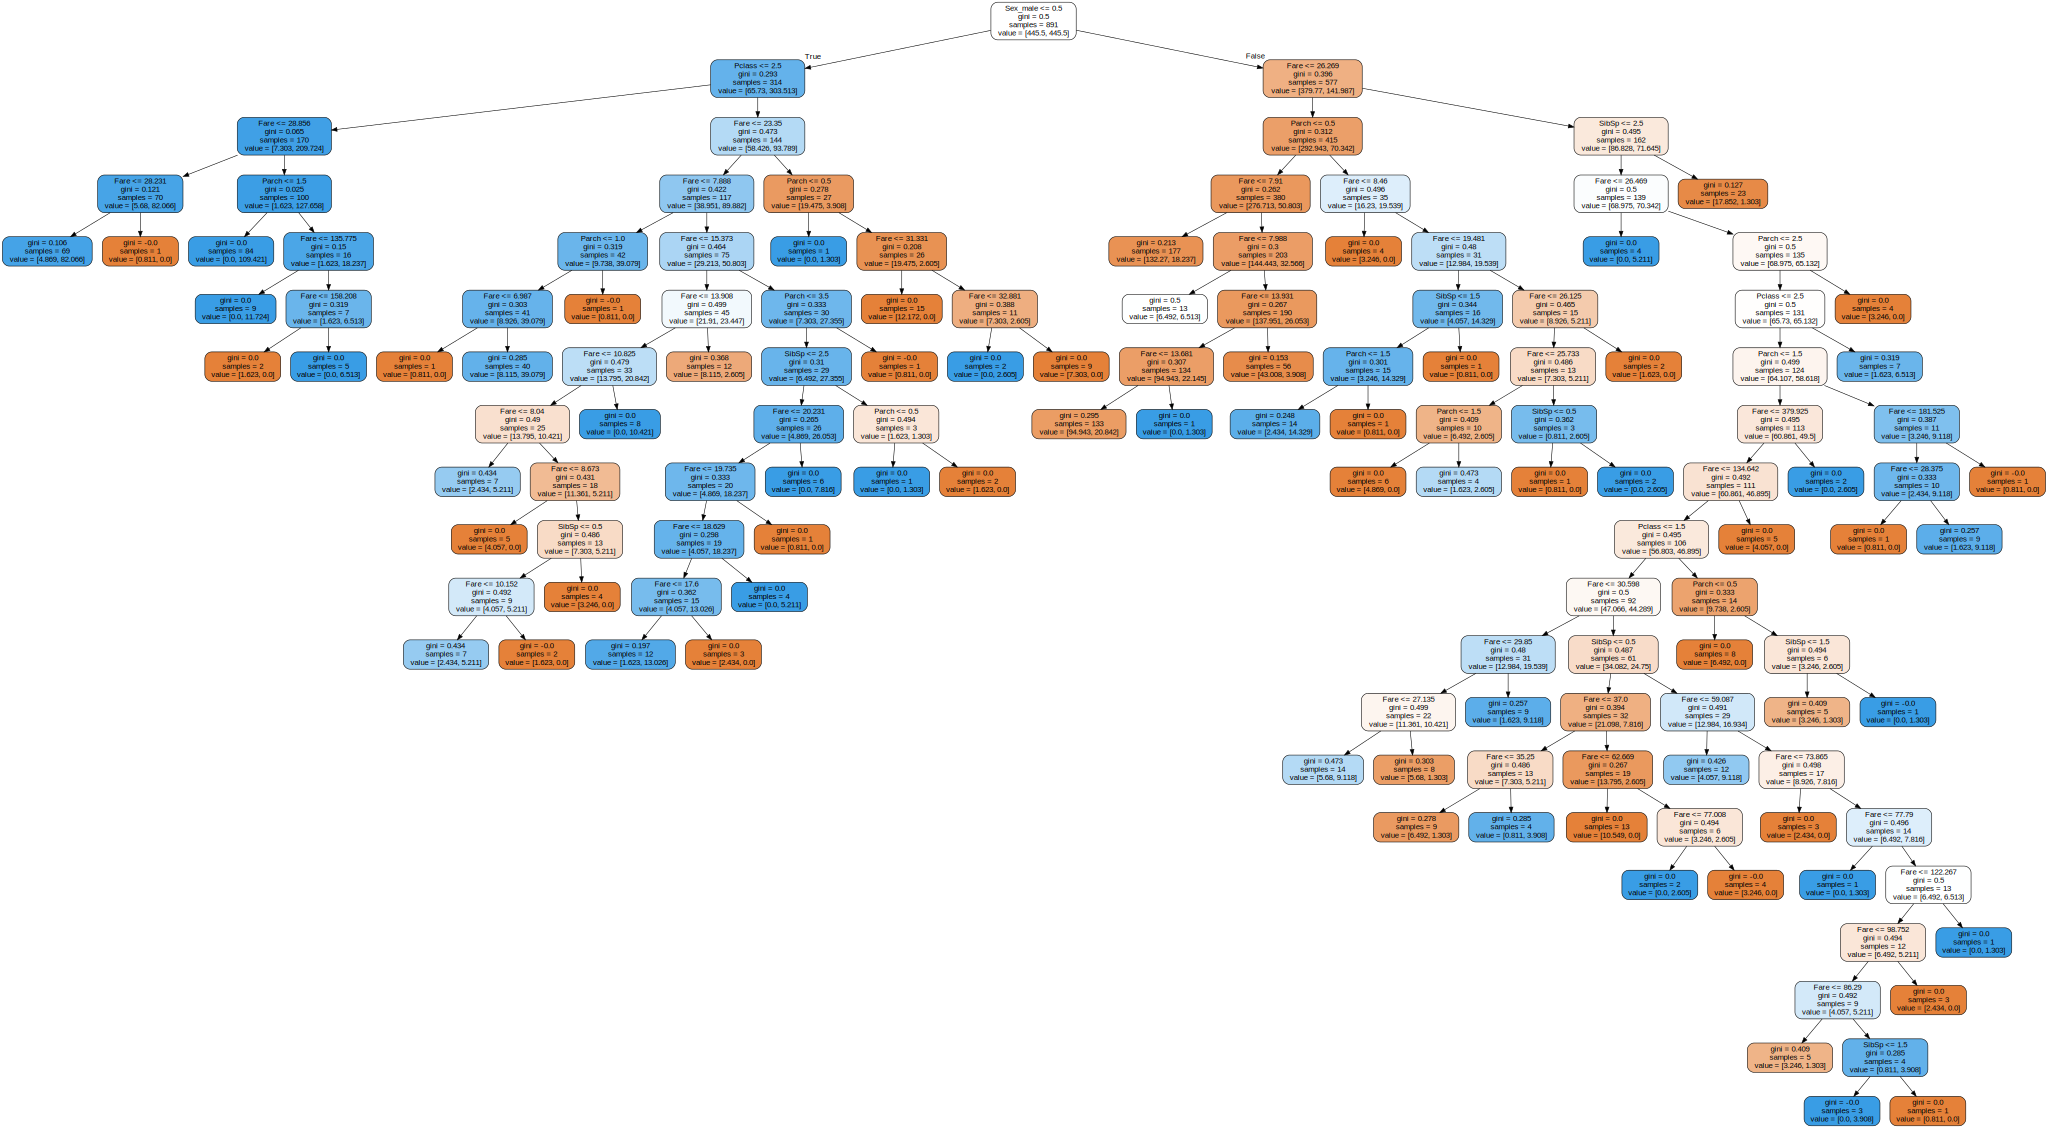

In [17]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(
    model_sub,
    out_file=None,
    feature_names=feature_names,
    filled=True,
#     leaves_parallel=True,
    rounded=True,

)
graphviz.Source(tree_graph)

In [18]:
path = model_sub.cost_complexity_pruning_path(X_train_transformed, y_train)
path

{'ccp_alphas': array([ 0.00000000e+00, -1.73472348e-18,  1.26449092e-18,  1.77028728e-18,
         2.16840434e-18,  2.44005060e-18,  4.06675101e-18,  4.88010121e-18,
         4.88010121e-18,  4.88010121e-18,  5.05796367e-18,  5.05796367e-18,
         1.01159273e-17,  1.64703416e-17,  5.46260076e-17,  5.31009115e-06,
         1.25881372e-05,  3.80515594e-05,  4.57533638e-05,  5.54656573e-05,
         7.10285648e-05,  7.69867053e-05,  1.49172991e-04,  1.49172991e-04,
         2.33795029e-04,  2.39058576e-04,  2.76110440e-04,  2.78430338e-04,
         2.83460054e-04,  3.33125079e-04,  3.91007380e-04,  4.90226717e-04,
         4.93648687e-04,  5.38638977e-04,  5.38640956e-04,  5.64910045e-04,
         5.90467714e-04,  6.25962471e-04,  6.57138163e-04,  6.86002941e-04,
         7.21269688e-04,  7.29779991e-04,  7.55465247e-04,  8.60941010e-04,
         9.43396226e-04,  9.43396226e-04,  9.55251738e-04,  9.61992459e-04,
         9.83161406e-04,  9.85707245e-04,  9.85707245e-04,  9.85836807e-04

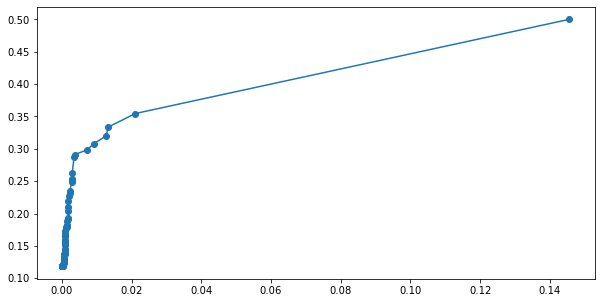

In [19]:
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    ccp_alphas, impurities,
    marker='o',
)
plt.show()

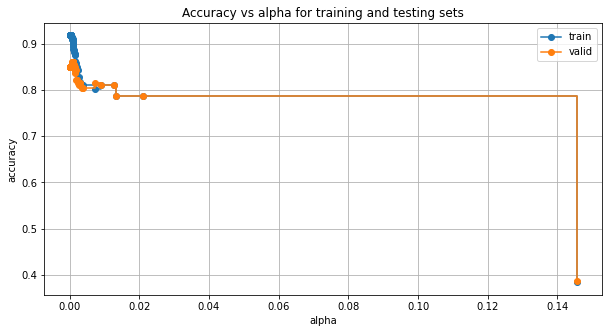

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, class_weight='balanced')
    clf.fit(X_train_transformed, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train_transformed, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid_transformed, y_valid) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid",
        drawstyle="steps-post")
ax.legend()
ax.grid()
plt.show()